# Исследование трендов российского кинопроката

Нужно изучить рынок российского кинопроката и выявить текущие тренды.

Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск.

## Описание данных:
У одного фильма может быть несколько прокатных удостоверений. 
- `title` — название фильма;
- `puNumber` — номер прокатного удостоверения;
- `show_start_date` — дата премьеры фильма;
- `type` — тип фильма;
- `film_studio` — студия-производитель;
- `production_country` — страна-производитель;
- `director` — режиссёр;
- `producer` — продюсер;
- `age_restriction` — возрастная категория;
- `refundable_support` — объём возвратных средств государственной поддержки;
- `nonrefundable_support` — объём невозвратных средств государственной поддержки;
- `financing_source` — источник государственного финансирования;
- `budget` — общий бюджет фильма;
- `ratings` — рейтинг фильма на КиноПоиске;
- `genres` — жанр фильма.
- `puNumber` — номер прокатного удостоверения;
- `box_office` — сборы в рублях.

Столбец `budget` уже включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. 

In [1]:
!python -m pip install Levenshtein

In [2]:
import pandas as pd
import numpy as np
from Levenshtein import distance
from matplotlib import pyplot as plt
from datetime import datetime as dt

## Подготовка данных

### Откроем файл с данными и изучим общую информацию

In [3]:
try:
    df1 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_movies.csv")
    df2 = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Composite_Project_1\source\mkrf_shows.csv")
except:
    df1 = pd.read_csv("/datasets/mkrf_movies.csv")
    df2 = pd.read_csv("/datasets/mkrf_shows.csv")

pd.set_option('display.max_columns', None)
print(df1.head(20))
print(df2.head(20))


                                                title   puNumber  \
0                                    Открытый простор  221048915   
1                                Особо важное задание  111013716   
2                                        Особо опасен  221038416   
3                                        Особо опасен  221026916   
4                                        Особо опасен  221030815   
5                                   Остановился поезд  111013816   
6                                     Любовь и голуби  111007013   
7                                   Любовь и сигареты  221074614   
8                                  Отпетые мошенники.  121011416   
9                                 Отпуск за свой счет  111019114   
10  Превосходство Борна /По одноименной новелле Ро...  221031416   
11                                       Ответный ход  111019014   
12  Малышка на миллион /По мотивам рассказов Ф.Х.Т...  221011415   
13                                 Преданный сад

Преобразуем колонки к соответствующим типам данных.

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

Поле `puNumber` содержит недопустимые для целочисленного типа значения. Точно так же поле `ratings` содержит недопустимые для вещественного типа значения. Преобразуем эти колонки к соответствующим типам через to_numeric() и оптимизируем типы для имеемых значений этих полей.

In [5]:
df1["puNumber"] = pd.to_numeric(df1["puNumber"], errors="coerce", downcast="integer")
df1["ratings"] = pd.to_numeric(df1["ratings"], errors="coerce", downcast="float")

In [6]:
df1 = df1.astype({"puNumber" : "UInt32", "show_start_date" : "datetime64"})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   object        
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Заметим, что поле `age_restriction` можно преобразовать к беззнаковому целыму типу. Преобразуем это поле. 

In [7]:
df1["age_restriction"] = pd.to_numeric(df1["age_restriction"].str.extract(r"(«\d*\+»)")[0].str.strip("«+»"), errors="coerce", downcast="unsigned")

Оптимизируем все строковые поля с уникальностью значений ниже 50%.

In [8]:
columns = df1.select_dtypes(include=['object'])

for col in columns:
    num_unique_values = len(df1[col].unique())
    num_total_values = len(df1[col])
    uniquness = num_unique_values / num_total_values

    print(col, f"uniquness is {uniquness * 100:.2f}%")

    if uniquness < 0.5:
        df1.loc[:,col] = df1[col].astype('category')
    else:
        df1.loc[:,col] = df1[col]

title uniquness is 90.46%
type uniquness is 0.08%
film_studio uniquness is 73.26%
production_country uniquness is 12.49%
director uniquness is 64.15%
producer uniquness is 71.39%
financing_source uniquness is 0.05%
genres uniquness is 9.93%


Проверим результат.

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   category      
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   category      
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   uint8         
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    category      
 13  rat

Так же преобразуем типы во втором датасете.

In [10]:
df2 = df2.astype({"puNumber" : "UInt32"})

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   UInt32 
 1   box_office  3158 non-null   float64
dtypes: UInt32(1), float64(1)
memory usage: 40.2 KB


Объединим эти данные в один DataFrame через left join df1 к df2 т.к. во втором содежжится только часть записей первого.

In [12]:
df = df1.merge(df2, on='puNumber', how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   puNumber               7485 non-null   UInt32        
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   category      
 4   film_studio            7468 non-null   object        
 5   production_country     7484 non-null   category      
 6   director               7477 non-null   object        
 7   producer               6918 non-null   object        
 8   age_restriction        7486 non-null   uint8         
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    category      
 13  rat

### Обработаем пропуски

In [13]:
df.isna().sum()

title                       0
puNumber                    1
show_start_date             0
type                        0
film_studio                18
production_country          2
director                    9
producer                  568
age_restriction             0
refundable_support       7154
nonrefundable_support    7154
budget                   7154
financing_source         7154
ratings                   996
genres                    976
box_office               4328
dtype: int64

Посмотрим на фильм без номера прокатного удостоверения `puNumber` чтобы принять решение о полезности этой записи.

In [14]:
df[df["puNumber"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
1797,Курбан-роман. (История с жертвой),<NA>,2014-05-15 12:00:00,Художественный,"ФОНД ""ИННОВАЦИЯ""",Россия,С.Юзеев,М.Галицкая,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку эта запись не содержит полезной для целий аналитики данных, избавимся от неё.

In [15]:
df = df[df["puNumber"].notna()]

Пропуски в поле со студией-производителем `film_studio` фильма не влияют на цели анализа и не могут быть алгоритмически заполнены, поэтому оставим их.

Рассмотрим фильмы с пропуском в стране производства `production_country`.

In [16]:
df[df["production_country"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
3186,"Детский юмористический киножурнал ""Ералаш. Ну ...",111001216,2016-02-09 12:00:00,Художественный,"ООО ""Продюсерский центр ЕРАЛАШ""",NaN,"Р.Светлов, И.Магитон, А.Арутюнян, Л.Мирский, А...","ООО ""Продюсерский центр ЕРАЛАШ""",0,NaN,NaN,NaN,NaN,7.2,"детский,комедия",194527.0
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN


In [17]:
df["production_country"].unique()

['США', 'СССР', 'Франция', 'СССР, Венгрия', 'Германия-Великобритания', ..., 'КНР - Франция', 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]
Length: 935
Categories (934, object): ['США', 'СССР', 'Франция', 'СССР, Венгрия', ..., 'Дания, Норвегия, Швеция, Исландия', 'Республика Кипр, США, Россия', 'Новая Зеландия - КНР', 'Дания - Канада - Швеция - Франция - Германия ...]

Заполним пропуски вручную т.к. понятно, что страна производства этих фильмов - РФ.

In [18]:
df.loc[df["production_country"].isna(), "production_country"] = "Россия"

Заполним пропуски в поле `director` вручную воспользовавшись поиском.

In [19]:
df[df["director"].isna()]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
764,"Три звезды. Концерт в Waldbuhne Theater, Берли...",126003512,2012-12-04 12:00:00,Прочие,Райзинг Алтернатив,Великобритания,NaN,Вальдбюне Театр,0,NaN,NaN,NaN,NaN,NaN,NaN,44350.0
1735,Помпеи. Британский музей,126003413,2013-09-11 12:00:00,Прочие,"МортуСкрин, Британский музей",Великобритания,NaN,Британский музей,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3840,Зур концерт (Большой концерт).,217027010,2010-06-24 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4052,"Ганс Сэйфуллин ""Авылым чишмэлэре. Ганс Сэйфулл...",217017310,2010-04-22 12:00:00,Художественный,"ООО ""Барс-Рекордс""",Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4298,Изге Вэли (Святой Валентин),217020610,2010-05-20 12:00:00,Художественный,"ООО ""Барс Рекордс""",Россия,NaN,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4415,Bon Jovi. The Circle Tour,126001710,2010-11-11 12:00:00,Прочие,Эншутц Интертейнмент Груп,США,NaN,Эншутц Интертейнмент Груп,0,NaN,NaN,NaN,NaN,7.9,"концерт,музыка",NaN
4441,Мульт личности. Выпуск 5,214000410,2010-01-25 12:00:00,Художественный,NaN,Россия,NaN,NaN,0,NaN,NaN,NaN,NaN,4.0,"мультфильм,комедия",NaN
4923,Георг Фридрих Гендель. Мессия. Оратория. Корол...,126001111,2011-04-25 12:00:00,Прочие,Опус Арт,Великобритания,NaN,Короевский колледж Кембриджа,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4942,Питер Гэбриэл и New Blood Orchestra 3D,126002711,2011-11-11 12:00:00,Прочие,Омниверс Визион,Великобритания,NaN,Омниверс Визион,0,NaN,NaN,NaN,NaN,6.7,"концерт,музыка",NaN


Поиск информации о режессёрах этих фильмов не дал результатов, поэтому оставим пропуски как есть.

Оставшиеся поля с пропусками не подлежат алгоритмическому заполнению. В случае с рейтингами или жанрами фильмов, их просто нет на площадке. Отсутствующая информация о финансировании означает, что проект не субсидировался.

### Обработаем дубликаты

Проверим наличие явных дубликатов.

In [20]:
df.duplicated().sum()

0

In [21]:
df.duplicated(["title", "puNumber"]).sum()

0

Удалим дубликаты, которые отличаются случайными символами.

In [22]:
df["title"] = df["title"].str.strip("._- ")
df["title"] = df["title"].str.replace('ё', 'e')
df["title"] = df["title"].str.lower()

In [23]:
df = df.drop_duplicates(["title", "puNumber"])

Воспользуемся расстоянием Левенштайна между строками чтобы найти неявные дубликаты т.к. уникальных значений достаточно много чтобы обрабатывать их вручную и достаочно мало, чтобы алгоритм сработал за относительно непродолжительное время. 

In [24]:
def print_duplicates(strings, dist):
    duplicates_count = 0

    for i in range(0, len(strings)):
        for j in range(i, len(strings)):
            if i == j: continue

            if distance(strings.iloc[i], strings.iloc[j]) <= dist:
                print(f"{i}: {strings.iloc[i]} \t{j}: {strings.iloc[j]}")
                duplicates_count += 1
            
    print(f"Duplicates count: {duplicates_count}")

Исследуем названия фильмов с одним отличием.

In [25]:
print_duplicates(df["title"], 1)

2: особо опасен 	3: особо опасен
2: особо опасен 	4: особо опасен
3: особо опасен 	4: особо опасен
12: малышка на миллион /по мотивам рассказов ф.х.тула из сборника "клейма от канатов"/ 	4606: малышка на миллион /по мотивам рассказов ф.х.тула из сборника "клейма от канатов"/
26: оружейный барон 	4609: оружейный барон
33: перелом 	4670: перелом
34: мисс поттер 	4605: мисс поттер
37: молчи в тряпочку 	4587: молчи в тряпочку
40: алекс и эмма 	41: алекс и эмма
40: алекс и эмма 	4580: алекс и эмма
41: алекс и эмма 	4580: алекс и эмма
44: адъютант его превосходительства 	1474: адъютант его превосходительства
50: асса 	93: васса
75: борис годунов 	5220: борис годунов
86: валентина 	6898: валентина
89: выстрел 	6686: выстрел
90: возмездие 	1478: возмездие
90: возмездие 	4341: возмездие
107: волшебная страна 	936: волшебная страна
107: волшебная страна 	937: волшебная страна
107: волшебная страна 	2119: волшебная страна
107: волшебная страна 	4652: волшебная страна
109: гарри поттер и орден фен

Проверим по индексам похожие на неявные дубликаты записи.

In [26]:
df.iloc[[738, 2053, 762, 1360, 937, 3560, 1581, 4427, 1737, 2467, 2375, 3983, 2392, 5727, 2448, 4176, 2838, 2866, 2866, 4735, 3203, 3918, 3940, 6380, 4076, 4429, 5894, 5957]]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
738,обливион,121004513,2013-02-21 12:00:00,Художественный,"Чернин Интертейнмент, Айрохед Студиос, Радикал...",США,Джозеф Косински,"Дилан Кларк, Джозеф Косински, Дункан Хендерсон",12,NaN,NaN,NaN,NaN,7.2,"фантастика,боевик,триллер",300.00
2054,мать мария,111025314,2014-12-24 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,С.Колосов,NaN,12,NaN,NaN,NaN,NaN,6.6,"драма,биография",NaN
762,вишенка на новогоднем торте,121030512,2012-12-17 12:00:00,Художественный,"Мэзон до Синема, Судэн Компани, Нат/Болт Прода...",Франция,Лаура Моранте,"Франческо Джиамматтео, Бруно Песери",16,NaN,NaN,NaN,NaN,5.8,комедия,NaN
1360,жорж бизе. кармен /по мотивам одноименной нове...,126003113,2013-09-03 12:00:00,Прочие,Синема Лайв,Австралия,"Брайан Томсон, Гейл Эдвардс",NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,волшебная страна,124001113,2013-04-15 12:00:00,Анимационный,"Брейктру Филмз, Эс Эм Бэ Инвестментс",Великобритания - Польша - КНР - Индия - Норвегия,"Мартин Клэпп, Дорота Кобеля, Джофф Линдси","Магдалена Баргел, Хью Велчман",18,NaN,NaN,NaN,NaN,7.9,"драма,семейный,биография",20260.00
3561,поезд в пусан,121030816,2016-11-17 12:00:00,Художественный,Контентс Панда,Южная Корея,Ён Сан-хо,"Ли Дон-ха, Ким Ён-хо",18,NaN,NaN,NaN,NaN,7.1,"ужасы,боевик,триллер",8459304.83
1581,другая женщина,121006814,2014-04-09 12:00:00,Художественный,"Эл Би И Продакшнз, ХХ век Фокс",США,Ник Кассаветис,"Дональд Дж.Ли младший, Чак Пачеко, Джули Силве...",16,NaN,NaN,NaN,NaN,6.7,"мелодрама,комедия",NaN
4428,гарри поттер и принц-полукровка /по роману дж....,221134610,2010-11-29 12:00:00,Художественный,"Уорнер Бразерс, Хэйдэй Филмз",США - Великобритания,Дэвид Йейтс,Дэйвид Хейман,12,NaN,NaN,NaN,NaN,7.7,"фэнтези,приключения,семейный",NaN
1737,как поймать перо жар-птицы,114000513,2013-10-11 12:00:00,Художественный,"ООО ""Визарт Фильм"", ООО ""Кинокомпания ""СТВ""",Россия,"В.Плотников, Г.Гитис","С.Сельянов, А.Лигай, С.Рапопорт, Ю.Москвин",0,NaN,NaN,NaN,NaN,5.2,"мультфильм,фэнтези",96846.00
2468,весь этот джем,111016515,2015-09-17 12:00:00,Художественный,"ООО ""Кинокомпания ""Спутник""",Россия,А.Адраникян,"А.Адраникян, В.Горяинов",16,NaN,NaN,NaN,NaN,5.0,"мелодрама,комедия",NaN


На основании ручного анализа схожих записей удалим неявные дубликаты. 

In [27]:
df = df.loc[df.index.drop([2745, 4698, 3194, 4366, 5068])]

In [28]:
df.duplicated(["title", "puNumber"]).sum()

0

Изучим категориальные поля. Удалим лишние символы в начале и конце всех строк с категориальными значениями.

In [29]:
df["type"] = df["type"].str.strip('._- ')
df["type"].value_counts()

Художественный                5903
Анимационный                   829
Прочие                         406
Документальный                 288
Научно-популярный               53
Музыкально-развлекательный       1
Name: type, dtype: int64

In [30]:
df["film_studio"] = df["film_studio"].str.strip('._- ')
df["film_studio"].value_counts()

Киностудия "Мосфильм"                                                                                                                                                            345
ООО "Мульт в кино"                                                                                                                                                                75
Анимаккорд Лтд                                                                                                                                                                    27
ООО "ТаББаК"                                                                                                                                                                      18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                                                                                                                            16
                                                                                               

In [31]:
df["film_studio"] = df["film_studio"].str.strip('._- ')
df["film_studio"].value_counts()

Киностудия "Мосфильм"                                                                                                                                                            345
ООО "Мульт в кино"                                                                                                                                                                75
Анимаккорд Лтд                                                                                                                                                                    27
ООО "ТаББаК"                                                                                                                                                                      18
ФГУП "ТПО "Киностудия "Союзмультфильм"                                                                                                                                            16
                                                                                               

In [32]:
df["production_country"] = df["production_country"].str.strip('._- ')
df["production_country"].value_counts()

США                                                       2172
Россия                                                    1822
СССР                                                       377
Франция                                                    301
Великобритания                                             259
                                                          ... 
Испания-Франция-Греция-Индия-США-Россия-Великобритания       1
Швейцария - Израиль - Франция - Великобритания               1
Россия-Германия                                              1
Финляндия - Великобритания - Германия                        1
Россия, Нидерланды, Финляндия                                1
Name: production_country, Length: 933, dtype: int64

In [33]:
df["director"] = df["director"].str.strip('._- ')
df["director"].value_counts()

О.Семёнова                                             60
Стивен Содерберг                                       17
Д.Червяцов                                             17
Ридли Скотт                                            16
Тиль Швайгер                                           14
                                                       ..
Бен Гез, Александра Кулак                               1
Карла Лиа Монти                                         1
В.Пономарёв, А.Миронов, Е.Салабай, В.Бедошвили и др     1
Онир                                                    1
Дик Маас                                                1
Name: director, Length: 4798, dtype: int64

In [34]:
df["producer"] = df["producer"].str.strip('._- ')
df["producer"].value_counts()

П.Смирнов                                             67
Олег Кузовков, Дмитрий Ловейко, Марина Ратина         28
С.Сельянов                                            18
Д.Ловейко, О.Кузовков                                 17
А.Тельнов                                             12
                                                      ..
Дженнифер Джейсон Ли, Скотт Рудин                      1
Лоренцо Ди Бонавентура, Киану Ривз, Стивен Хэймел      1
Роберт Б.Уайде                                         1
Франсуа д'Артемар, Владимир Кох, Анджей Якимовский     1
Аарон Барнетт, Эри Лантос, Роберт Лантош               1
Name: producer, Length: 5333, dtype: int64

In [35]:
df["genres"] = df["genres"].str.strip('._- ')
df["genres"].value_counts()

драма                            476
комедия                          352
мелодрама,комедия                222
драма,мелодрама,комедия          189
драма,мелодрама                  183
                                ... 
триллер,мелодрама,детектив         1
музыка,мелодрама,фэнтези           1
приключения,драма,фантастика       1
фэнтези,боевик,криминал            1
фэнтези,мелодрама,приключения      1
Name: genres, Length: 742, dtype: int64

Обновим индекс после чистки данных.

In [36]:
df = df.reset_index(drop=True)

Изучим столбцы с количественными значениями.

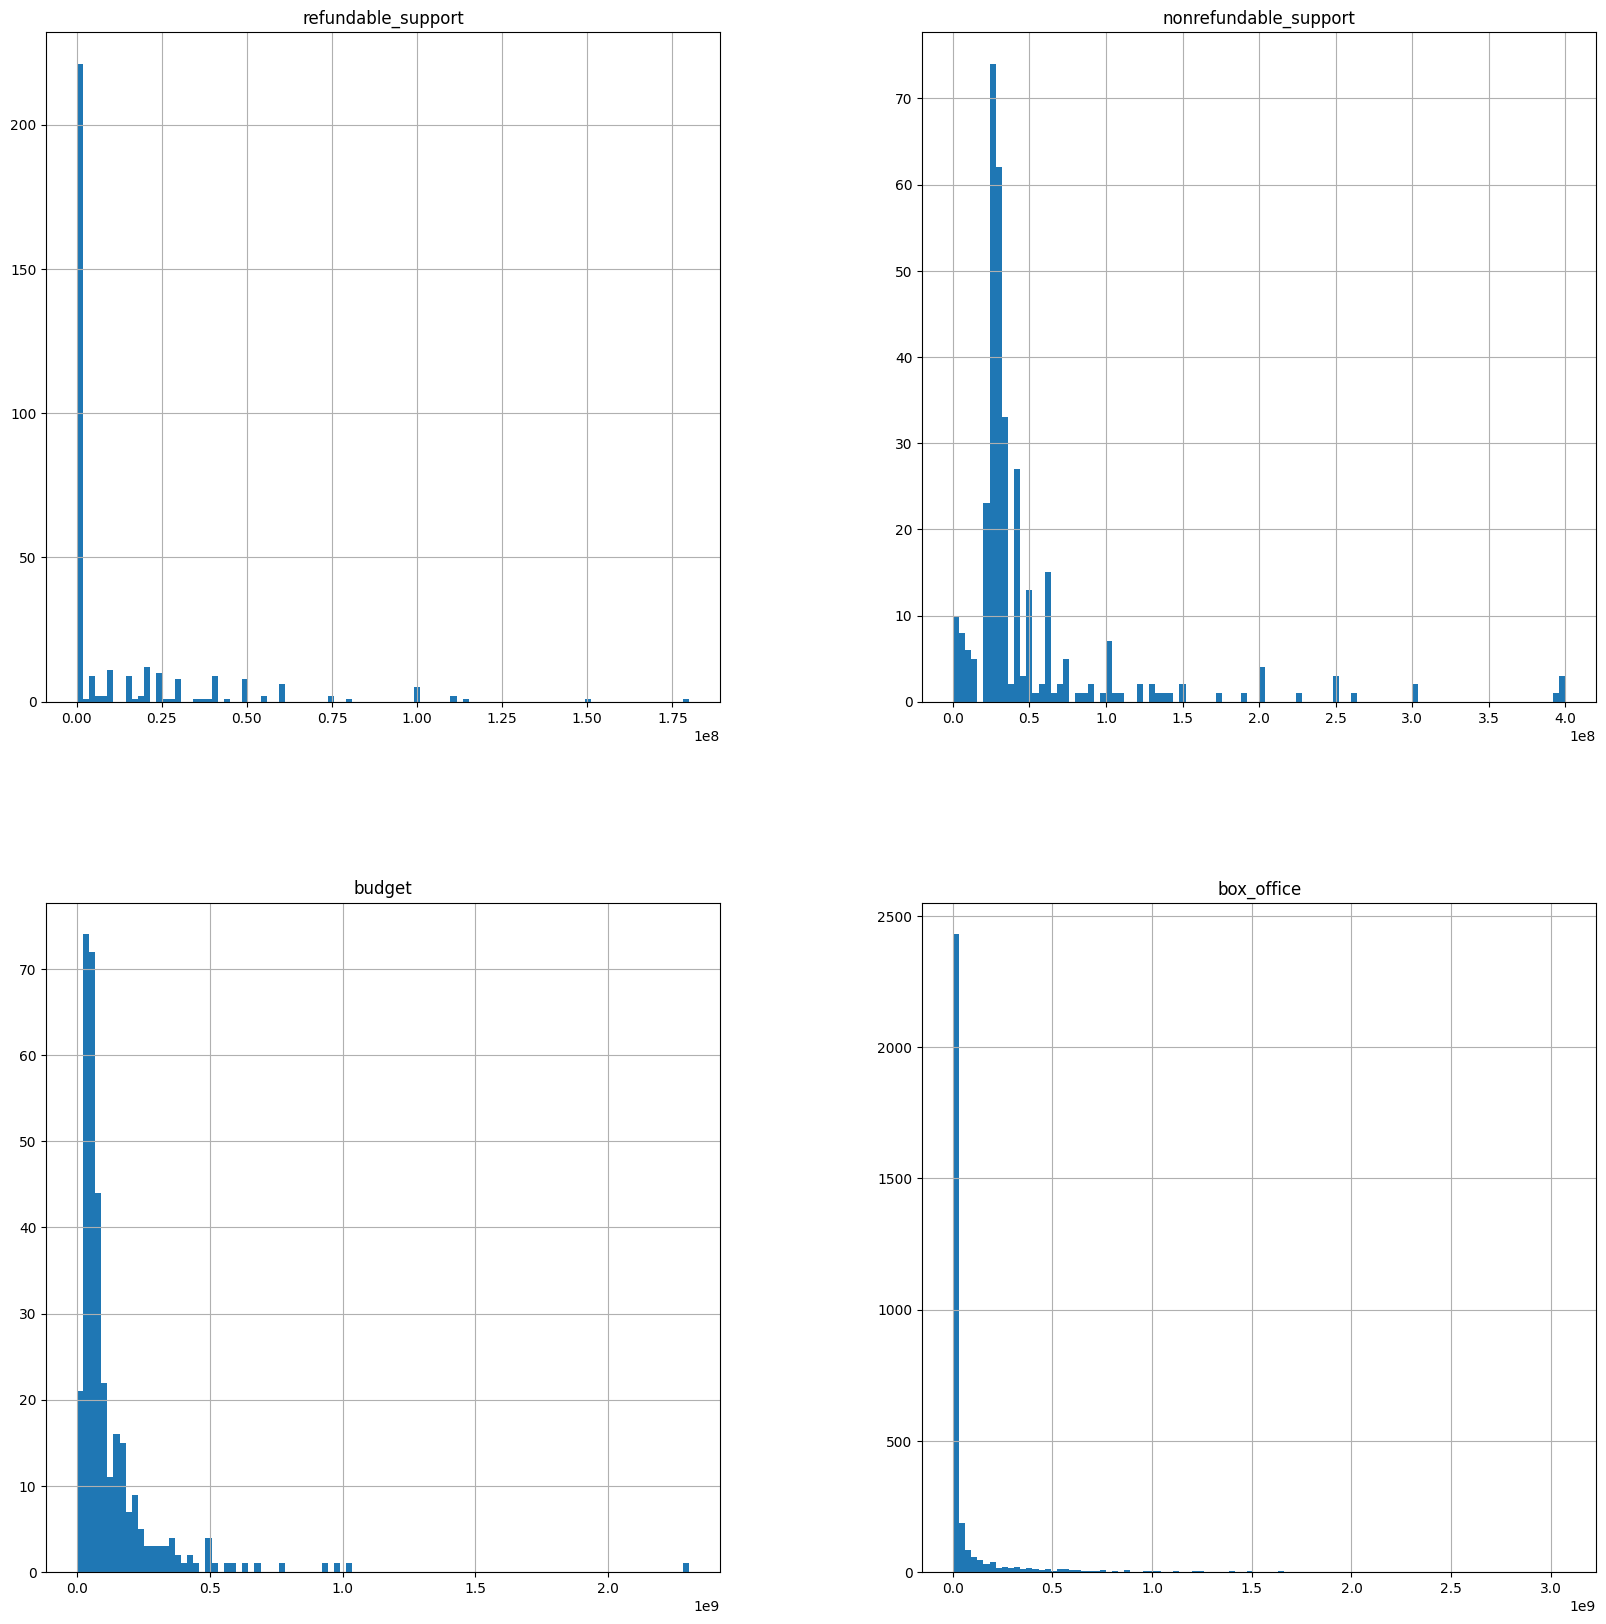

In [37]:
numeric = df.select_dtypes(include=['float', 'int'])
numeric.hist(bins=100, figsize=(20, 20));

Явно видно что бюджеты субсидий большинства фильмов сосредоточены в достаточно узком диапазоне. Рассмотрим каждое из полей подробнее используя wiskers.

refundable_support


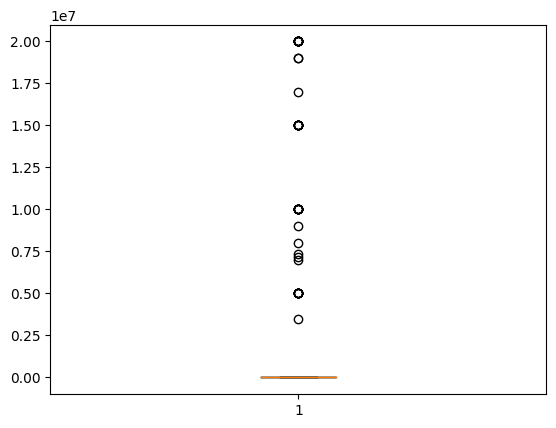

nonrefundable_support


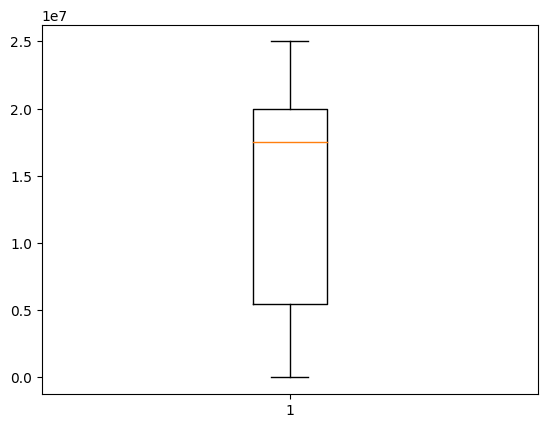

budget


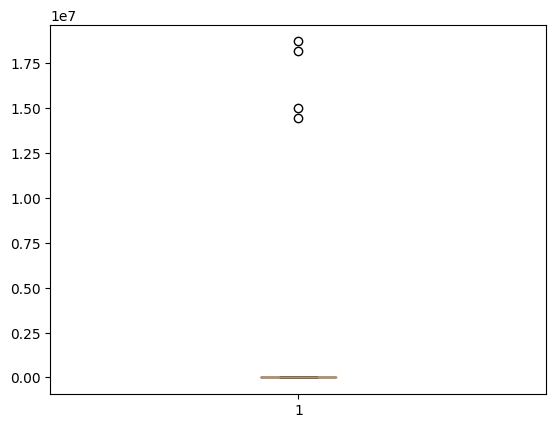

box_office


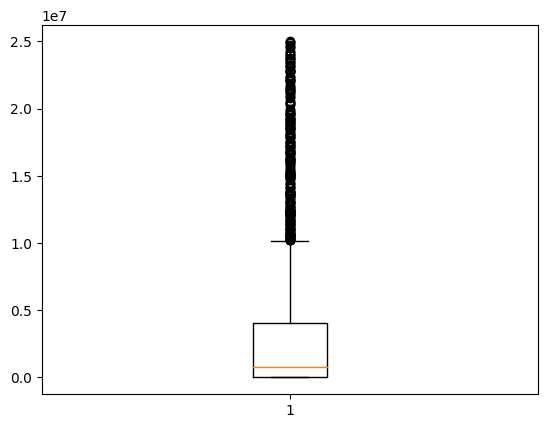

In [38]:
for col in numeric.columns:
    print(col)
    plt.boxplot(df.loc[(df[col].notna()) & (df[col] < 25_000_000), col]);
    plt.show()

Заметим, что проекты с безвозмездной поддержкой получают большие, чем остальные, субсидии. Отмасштабируем остальные финансовые поля.

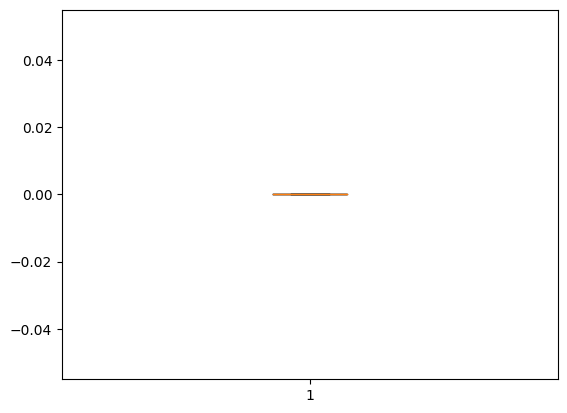

In [39]:
plt.boxplot(df.loc[(df["refundable_support"].notna()) & (df["refundable_support"] < 1_00_000), "refundable_support"]);

Кажется, что данные искажены нулевыми значениями. Проверим описательную статистику.

In [40]:
for col in numeric.columns:
    print(df[col].describe(), '\n')

count    3.320000e+02
mean     1.186446e+07
std      2.491656e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.500000e+07
max      1.800000e+08
Name: refundable_support, dtype: float64 

count    3.320000e+02
mean     4.898099e+07
std      5.998012e+07
min      0.000000e+00
25%      2.500000e+07
50%      3.000000e+07
75%      4.037500e+07
max      4.000000e+08
Name: nonrefundable_support, dtype: float64 

count    3.320000e+02
mean     1.272297e+08
std      1.885883e+08
min      0.000000e+00
25%      4.200000e+07
50%      6.864992e+07
75%      1.419853e+08
max      2.305074e+09
Name: budget, dtype: float64 

count    3.157000e+03
mean     7.650292e+07
std      2.403873e+08
min      0.000000e+00
25%      8.638600e+04
50%      2.330104e+06
75%      2.398312e+07
max      3.073569e+09
Name: box_office, dtype: float64 



Заменим на None нулевые значения, чтобы анализировать только субсидируемые картины. 

In [41]:
for col in numeric.columns:
    df[col] = df[col].replace(0, np.nan)

Рассмотрим графики ещё раз после замены.

refundable_support


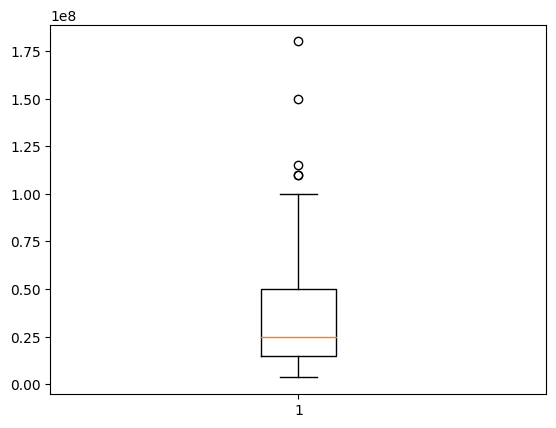

nonrefundable_support


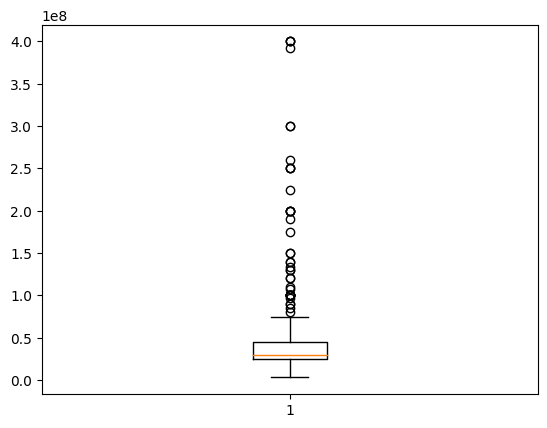

budget


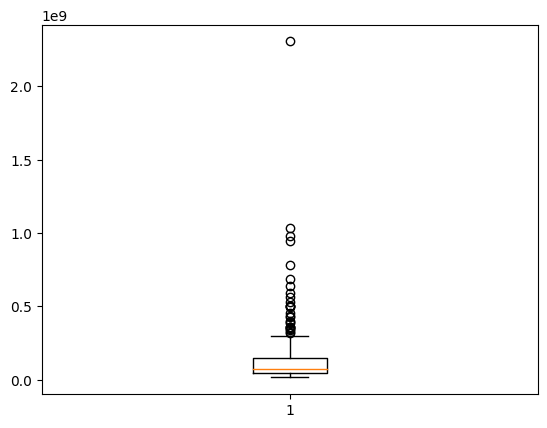

box_office


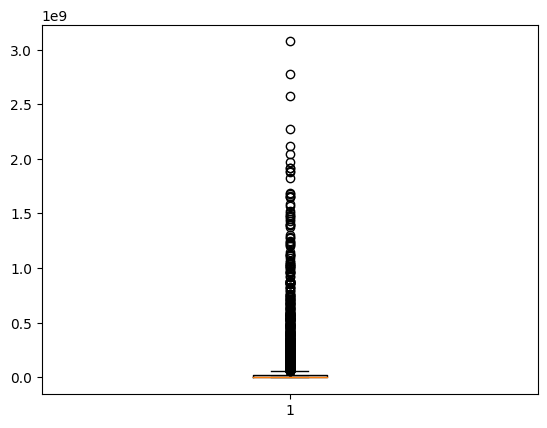

In [42]:
for col in numeric.columns:
    print(col)
    plt.boxplot(df.loc[(df[col].notna()), col]);
    plt.show()

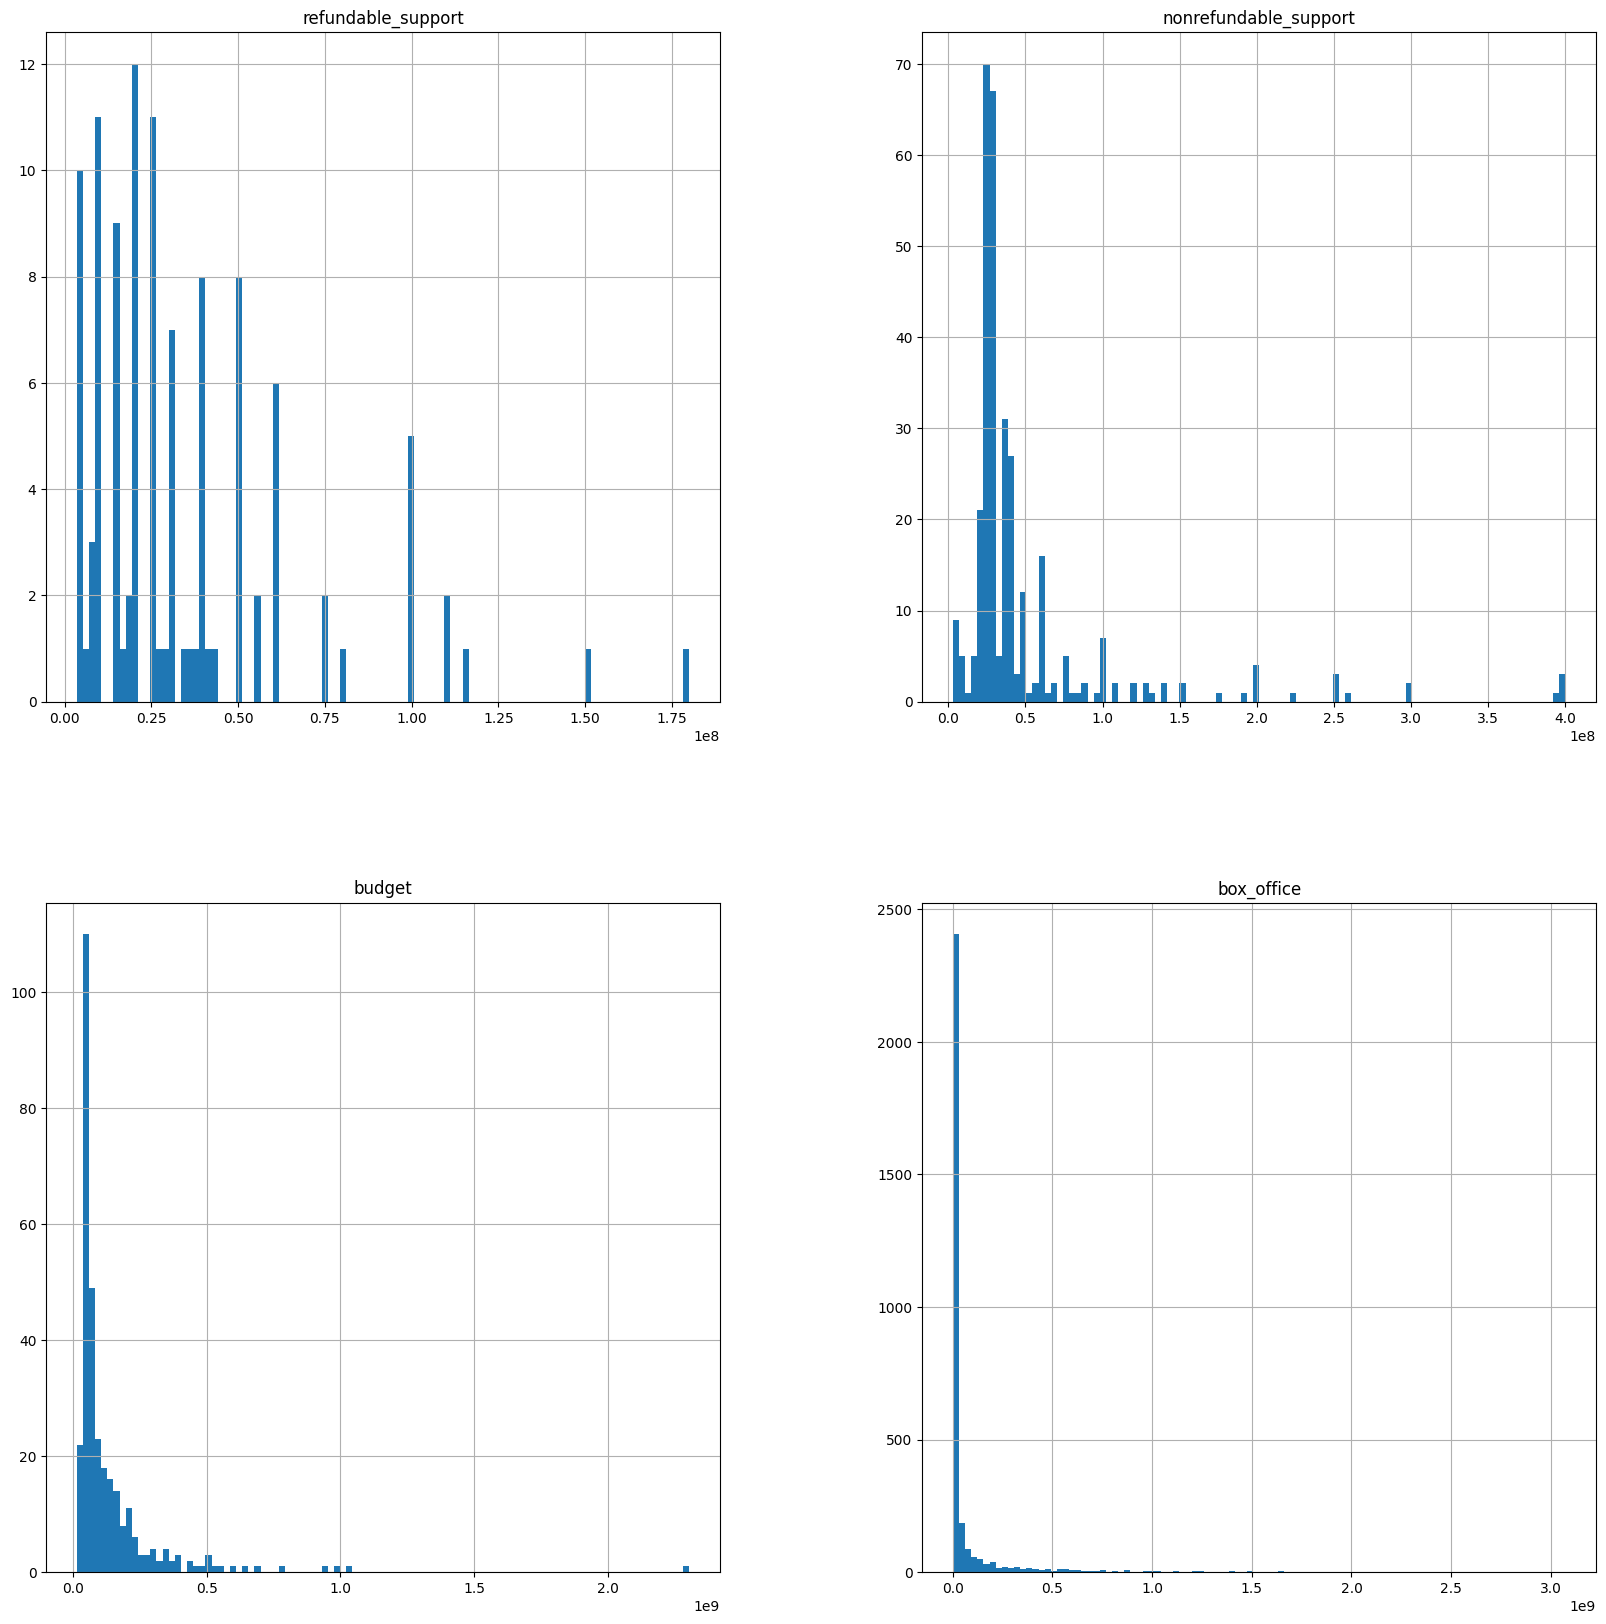

In [43]:
numeric = df.select_dtypes(include=['float', 'int'])
numeric.hist(bins=100, figsize=(20, 20));

Неясно выглядят графики для `box_office`. Отмасштабируем их, чтобы понять, какие значения считать выбросами.

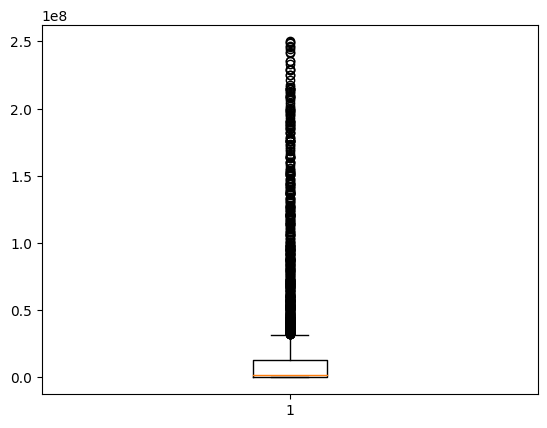

In [44]:
plt.boxplot(df.loc[(df["box_office"].notna() & (df["box_office"] <= 250_000_000)), "box_office"]);

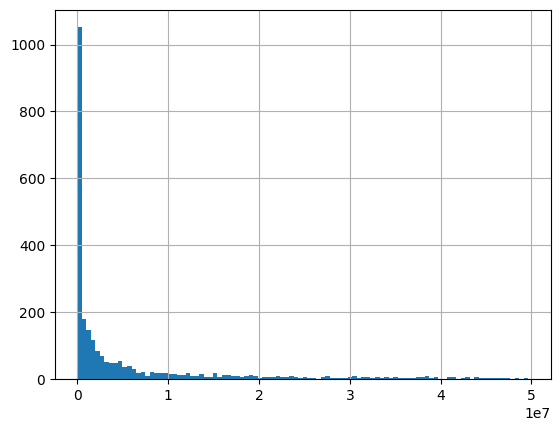

In [45]:
df.loc[(df["box_office"].notna()) & (df["box_office"] <= 50_000_000), "box_office"].hist(bins=100);

Наблюдаем финансовую статистику с длинными хвостами. Учитывая цели исследования по нахождению трендов заметим, что выбросами можно считать значения более 100_000_000 для `refundable_support`, 75_000_000 для `nonrefundable_support`, 250_000_000 для `budget` и 40_000_000 для `box_office`.

### Добавим новые столбцы

In [46]:
df[df["refundable_support"] < 0]

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office


In [47]:
df["start_year"] = df["show_start_date"].dt.year
df["main_director"] = df["director"].str.split(',', 1, expand=True)[0]
df["main_genre"] = df["genres"].str.split(',', 1, expand=True)[0]
df["grant_share"] = (100 * (df["refundable_support"] + df["nonrefundable_support"]) / df["budget"]).round(2)

df.head()

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,start_year,main_director,main_genre,grant_share
0,открытый простор,221048915,2015-11-27 12:00:00,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",18,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN,2015,Кевин Костнер,боевик,NaN
1,особо важное задание,111013716,2016-09-13 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,6,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN,2016,Е.Матвеев,драма,NaN
2,особо опасен,221038416,2016-10-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2016,Тимур Бекмамбетов,фантастика,NaN
3,особо опасен,221026916,2016-06-10 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2016,Тимур Бекмамбетов,фантастика,NaN
4,особо опасен,221030815,2015-07-29 12:00:00,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",18,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN,2015,Тимур Бекмамбетов,фантастика,NaN


Создадим набор данных без выбросов.

In [48]:
no_outliers = df.copy(deep=True)
no_outliers["refundable_support"] = df.loc[df["refundable_support"] <= 100_000_000, "refundable_support"]
no_outliers["nonrefundable_support"] = df.loc[df["nonrefundable_support"] <= 75_000_000, "nonrefundable_support"]
no_outliers["budget"] = df.loc[df["budget"] <= 250_000_000, "budget"]
no_outliers["box_office"] = df.loc[df["box_office"] <= 40_000_000, "box_office"]

Преобразуем типы данных колонок в наборе данных без выбросов.

In [49]:
columns = no_outliers.select_dtypes(include=['object'])

for col in columns:
    num_unique_values = len(no_outliers[col].unique())
    num_total_values = len(no_outliers[col])
    uniquness = num_unique_values / num_total_values

    print(col, f"uniquness is {uniquness * 100:.2f}%")

    if uniquness < 0.5:
        no_outliers.loc[:,col] = no_outliers[col].astype('category')
    else:
        no_outliers.loc[:,col] = no_outliers[col]

no_outliers.info()

title uniquness is 88.93%
type uniquness is 0.08%
film_studio uniquness is 72.98%
production_country uniquness is 12.47%
director uniquness is 64.16%
producer uniquness is 71.31%
genres uniquness is 9.93%
main_director uniquness is 61.50%
main_genre uniquness is 0.39%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7480 non-null   object        
 1   puNumber               7480 non-null   UInt32        
 2   show_start_date        7480 non-null   datetime64[ns]
 3   type                   7480 non-null   category      
 4   film_studio            7462 non-null   object        
 5   production_country     7480 non-null   category      
 6   director               7471 non-null   object        
 7   producer               6913 non-null   object        
 8   age_restriction        7480 n

## EDA

Исследуем, сколько фильмов выходило в прокат каждый год.

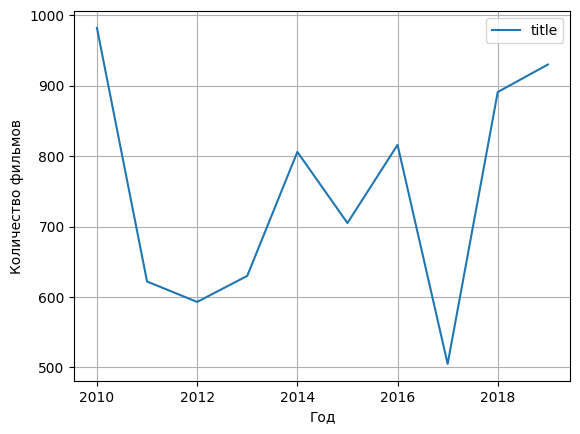

In [50]:
df.pivot_table(index="start_year", values="title", aggfunc="count").plot(xlabel="Год", ylabel="Количество фильмов", grid=True);

Частота выхода фильмов меняется год от года. В 2010'х выходило больше всего фильмов. Потом, к 2012 году, количество новых фильмов сильно сократилось и медленно росло до 2014 года. До 2016 года количество выходящих в прокат фильмов оставалось относительно неизменным и начало резко сокращаться к 2017 году, в котором новых фильмов вышло в прокат меньше всего. В 2018 году произошёл резкий рост количества новых фильмов, который продолжился в 2019 году с чуть меньшей динамикой.

Выясним долю фильмов с указанной информацией о прокате в кинотеатрах.

In [51]:
filled_share = 100 * df['box_office'].notna().sum() / len(df.index)

print(f"Доля фильмов с указанными кассовыми сборами: {filled_share:.2f}%")

Доля фильмов с указанными кассовыми сборами: 41.89%


### Изучим, как доля фильмов с информацией о их кассовых сборах менялась по годам

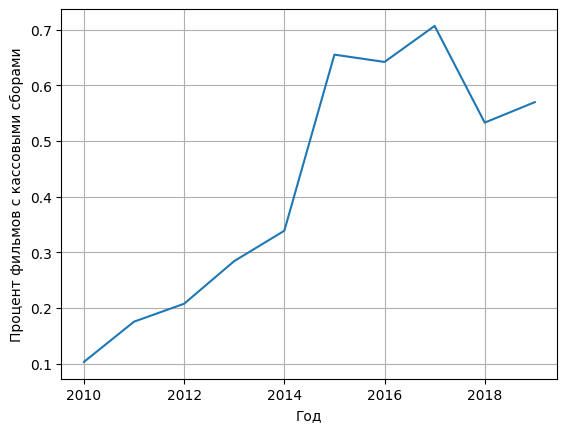

In [52]:
filled = df.pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["count", "size"]})
filled.columns = ["count", "size"]
filled["percent"] = filled["count"] / filled["size"]
filled["percent"].plot(xlabel="Год", ylabel="Процент фильмов с кассовыми сборами", grid=True);

Количество информации о фильмах росло год от года. Наиболее полные данные представлены за 2015-2018 годы.

### Изучим как менялась динамика проката по годам

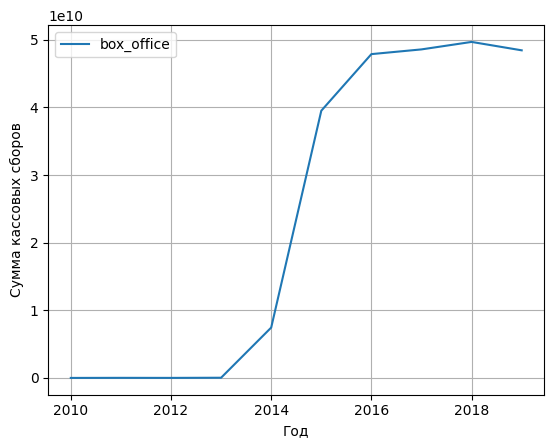

In [53]:
profits = df.pivot_table(index="start_year", values="box_office", aggfunc="sum").plot(xlabel="Год", ylabel="Сумма кассовых сборов", grid=True);

Сумма кассовых сборов увеличивалась с 2013 года и достигла максимальных значений в 2016+ годах. Наибольшие кассовые сборы со всех фильмов пришлись на 2018 год. Минимальные же сборы были в 2013б 2014 годах.

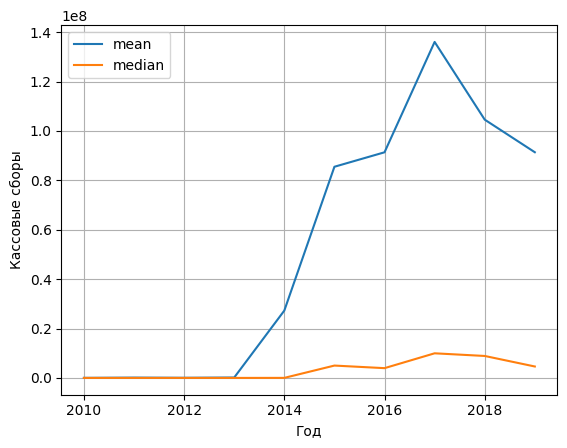

In [54]:
df.pivot_table(index="start_year", values="box_office", aggfunc={"box_office" : ["mean", "median"]}).plot(xlabel="Год", ylabel="Кассовые сборы", grid=True);

После 2013 года средние значения кассовых сборов начали расти стримительнее медианных. Пик этого разрыва пришёлся на 2017 год. Из этого можно сделать вывод, что с 2013 года в прокате начали с каждым годом всё чаще появляться всё более и более успешные относительно других актуальных фильмов картины.

### Определим влияние возрастного ограничения на сборы

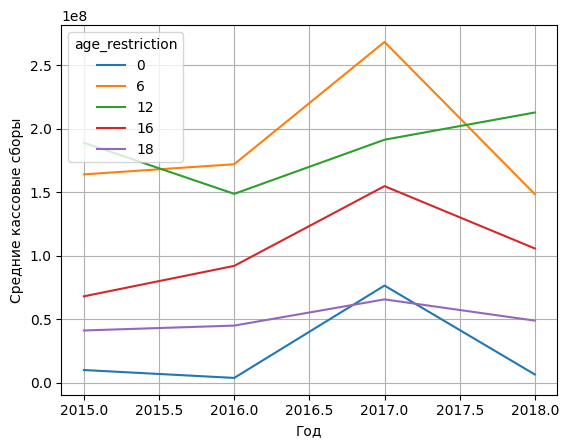

In [55]:
df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)].pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="mean").plot(xlabel="Год", ylabel="Средние кассовые сборы", grid=True);

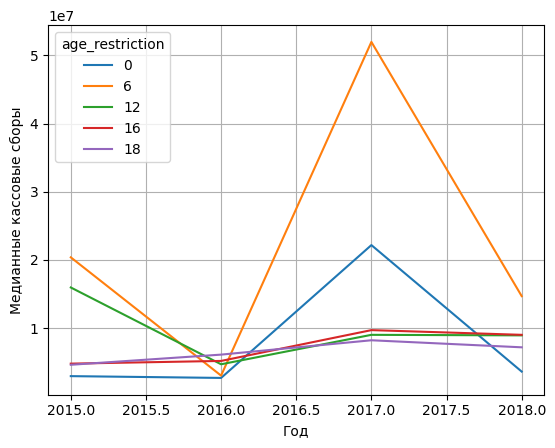

In [56]:
df[(df['start_year'] >= 2015) & (df['start_year'] < 2019)].pivot_table(index="start_year", columns="age_restriction", values="box_office", aggfunc="median").plot(xlabel="Год", ylabel="Медианные кассовые сборы", grid=True);

После анализа среднего и медианного значения кассовых сборов по годам в зависимости от возрастной категории фильмов очевидно, что наиболее успешны в прокате фильмы с возрастной категорией 6+. Однако, в силу демографических изменений этот тренд меняется в 2017 году т.к. в целевой аудитории 12+, вероятно, становится больше зрителей.

## Исследование государственного субсидирования

### Посмотрим на динамику суммарного субсидирования по годам

In [57]:
subsidized = no_outliers[no_outliers["refundable_support"].notna() | no_outliers["nonrefundable_support"].notna()]
subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311 entries, 1281 to 7472
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  311 non-null    object        
 1   puNumber               311 non-null    UInt32        
 2   show_start_date        311 non-null    datetime64[ns]
 3   type                   311 non-null    category      
 4   film_studio            311 non-null    object        
 5   production_country     311 non-null    category      
 6   director               311 non-null    object        
 7   producer               309 non-null    object        
 8   age_restriction        311 non-null    uint8         
 9   refundable_support     106 non-null    float64       
 10  nonrefundable_support  283 non-null    float64       
 11  budget                 272 non-null    float64       
 12  financing_source       311 non-null    category      
 13  r

Рассмотрим суммарные значения финансируемых безвозмездно и с возвратом проектов для набора данных без выбросов.

C:\Users\yka\AppData\Local\Temp\ipykernel_11280\1842422034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subsidized["grants"] = subsidized["nonrefundable_support"] + subsidized["refundable_support"]


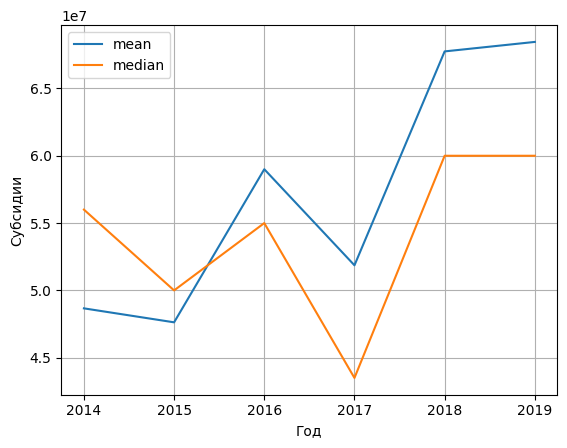

In [58]:
subsidized["grants"] = subsidized["nonrefundable_support"] + subsidized["refundable_support"]
avg_grants = pd.pivot_table(subsidized, index="start_year", values="grants", aggfunc={"grants" : ["mean", "median"]}) \
    .plot(xlabel="Год", ylabel="Cубсидии", grid=True);

Суммарные субсидии с большего растут год от года. При этом после 2015 года больше проектов начали получать большее относительно рынка субсидирование.

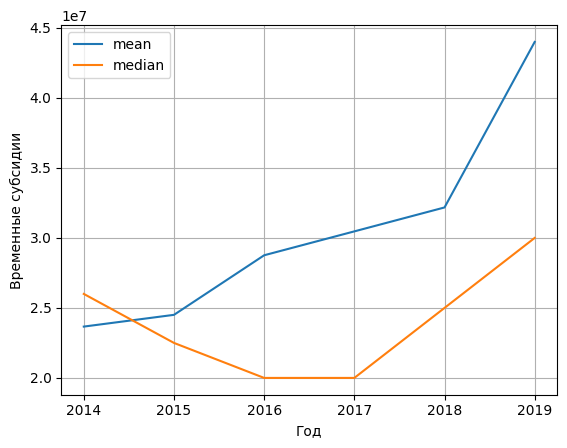

In [59]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc={"refundable_support" : ["mean", "median"]}).plot(xlabel="Год", ylabel="Временные субсидии", grid=True);

Заметим, что после 2013 года начали появляться проекты, которые получали больше временных субсидий, чем большинство остальных субсидируемых проектов.

Посмотрим, сколько всего субсидируемых с возвратами фильмов было по годам.

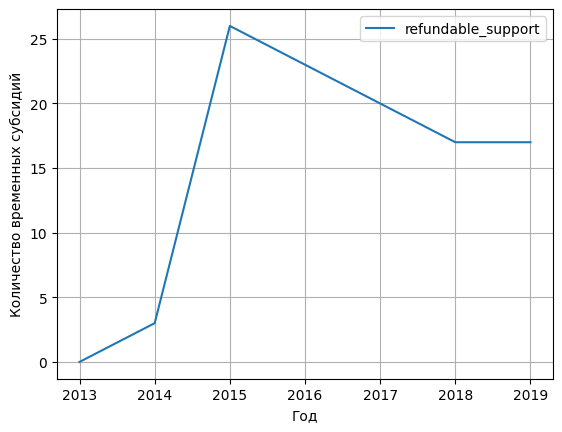

In [60]:
subsidized.pivot_table(index="start_year", values="refundable_support", aggfunc="count").plot(xlabel="Год", ylabel="Количество временных субсидий", grid=True);

Заметим, что количество временных субсидий отдалённо напоминает динамику суммарных кассовых сборов.

Проанализируем безвозмездные субсидии таким же образом.

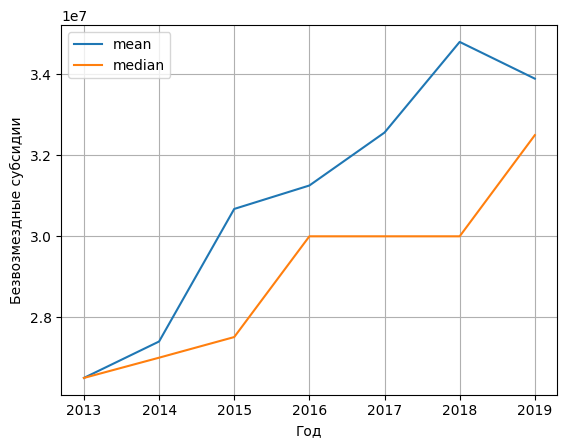

In [61]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc={"nonrefundable_support" : ["mean", "median"]}).plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True);

Заметим, что безвозмездные субсидии постоянно росли и на протяжении всего периода анализа каждый год есть проекты, которые получали безвозмездных субсидий чуть больше, чем остальные.

Посмотрим, сколько всего безвозмездно субсидируемых фильмов было по годам.

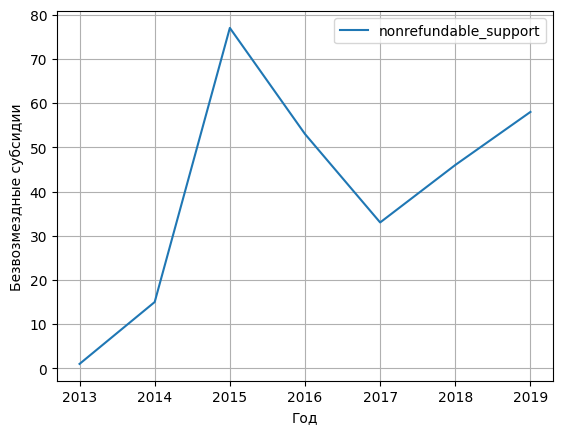

In [62]:
subsidized.pivot_table(index="start_year", values="nonrefundable_support", aggfunc="count").plot(xlabel="Год", ylabel="Безвозмездные субсидии", grid=True);

Динамика схожа со временными субсидиями, за исключением того, что в 2017 году безвозмездных субсидий начали давать значительно меньше, чем до этого.

### Проанализируем как субсидии влияют на коммерческую успешность проектов

Сначала рассмотрим временные, потом безвозмездные.

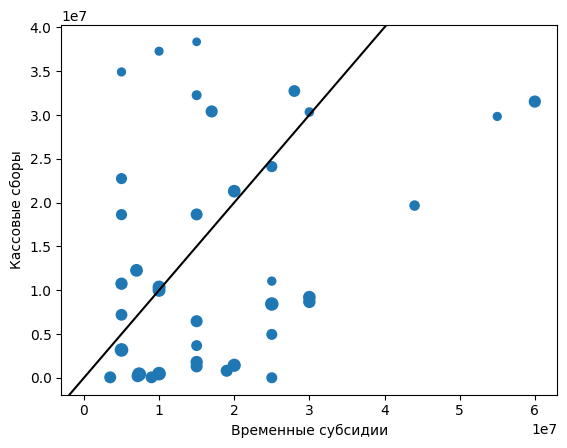

In [63]:
plt.scatter(x=subsidized["refundable_support"], y=subsidized["box_office"], s=subsidized["ratings"] * 10);
plt.axline((0, 0), (1, 1), color='k')
plt.xlabel("Временные субсидии")
plt.ylabel("Кассовые сборы")
plt.show()

Заметим, что лишь малая часть фильмов смогла превзойти размер временных субсидий кассовыми сборами. При этом рейтинг, который определяет размер точек на графике, чаще больший у фильмов, которые получили меньше прибыли, чем верменных субсидий. 

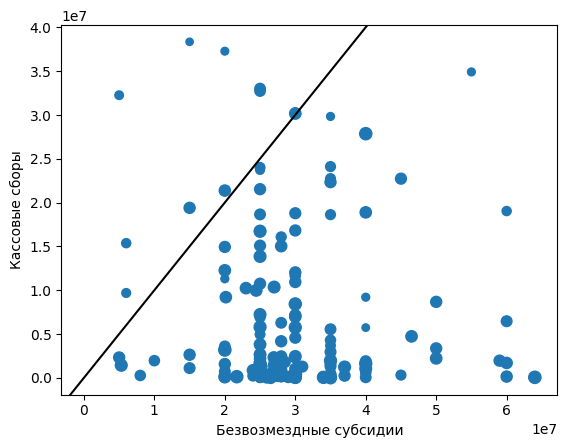

In [64]:
plt.scatter(x=subsidized["nonrefundable_support"], y=subsidized["box_office"], s=subsidized["ratings"] * 10);
plt.axline((0, 0), (1, 1), color='k')
plt.xlabel("Безвозмездные субсидии")
plt.ylabel("Кассовые сборы")
plt.show()

Для безвозмездных субсидий ситуация выглядит схожим образом. Ещё меньшее число проектов собирают в прокате больше, чем получают безвозмездных субсидий. При этом рейтинг большинства финансово "неуспешных" картин относительно высокий.

### Рассмотрим, какими признаками обладают финансово успешные проекты

In [65]:
succeded_subsidized = subsidized[subsidized["refundable_support"] + subsidized["nonrefundable_support"] > subsidized["box_office"]]
succeded_subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31 entries, 2534 to 7369
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  31 non-null     object        
 1   puNumber               31 non-null     UInt32        
 2   show_start_date        31 non-null     datetime64[ns]
 3   type                   31 non-null     category      
 4   film_studio            31 non-null     object        
 5   production_country     31 non-null     category      
 6   director               31 non-null     object        
 7   producer               31 non-null     object        
 8   age_restriction        31 non-null     uint8         
 9   refundable_support     31 non-null     float64       
 10  nonrefundable_support  31 non-null     float64       
 11  budget                 30 non-null     float64       
 12  financing_source       31 non-null     category      
 13  ra

Выделим категориальные признаки, которые влияют на успешность картины. 

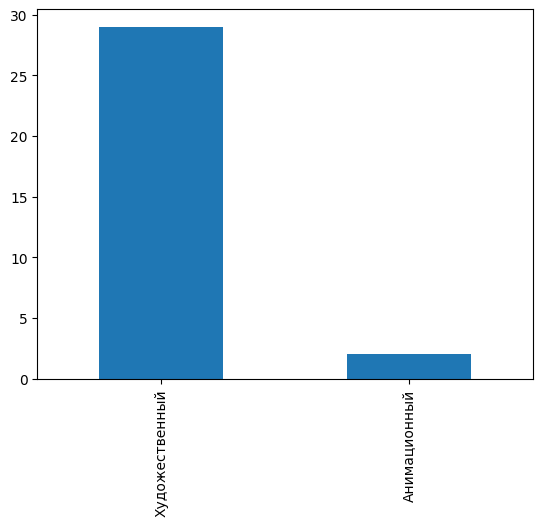

In [66]:
succeded_subsidized["type"].value_counts().loc[succeded_subsidized["type"].value_counts() > 0].plot.bar();

Предположим, что более успешными в прокате являются художественные фильмы. 

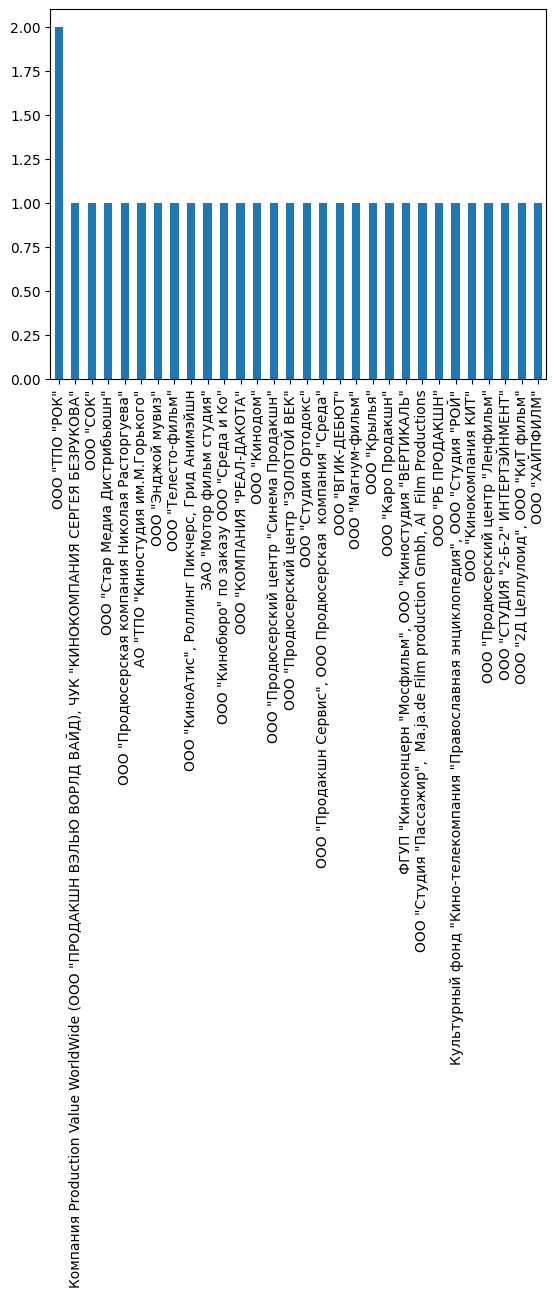

In [67]:
succeded_subsidized["film_studio"].value_counts().loc[succeded_subsidized["film_studio"].value_counts() > 0].plot.bar();

Получили список студий, которые чаще всего добиваются коммерческого успеха при получении субсидий.

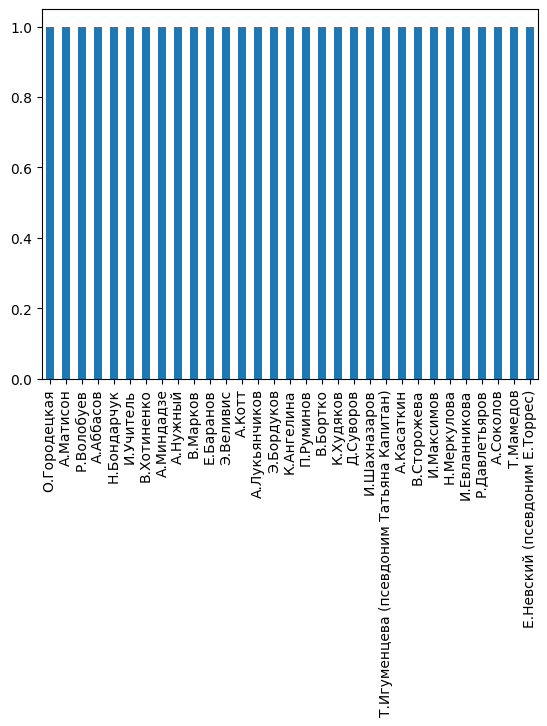

In [68]:
succeded_subsidized["main_director"].value_counts().loc[succeded_subsidized["main_director"].value_counts() > 0].plot.bar();

Получили список режиссёров, которые чаще остальных делают коммерчиски успешные проекты с учётом субсидирования.

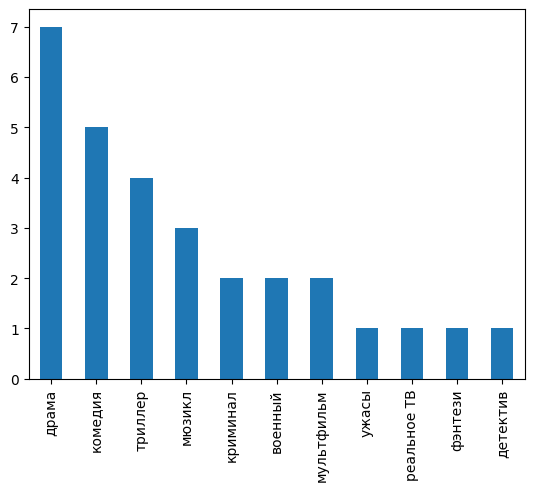

In [69]:
succeded_subsidized["main_genre"].value_counts().loc[succeded_subsidized["main_genre"].value_counts() > 0].plot.bar();

Выяснили, что основными жанрами, подходящим для субсидирования с целью получения коммерчески успешной картины являются драмы, комедии, мелодрамы, триллеры и мюзиклы.

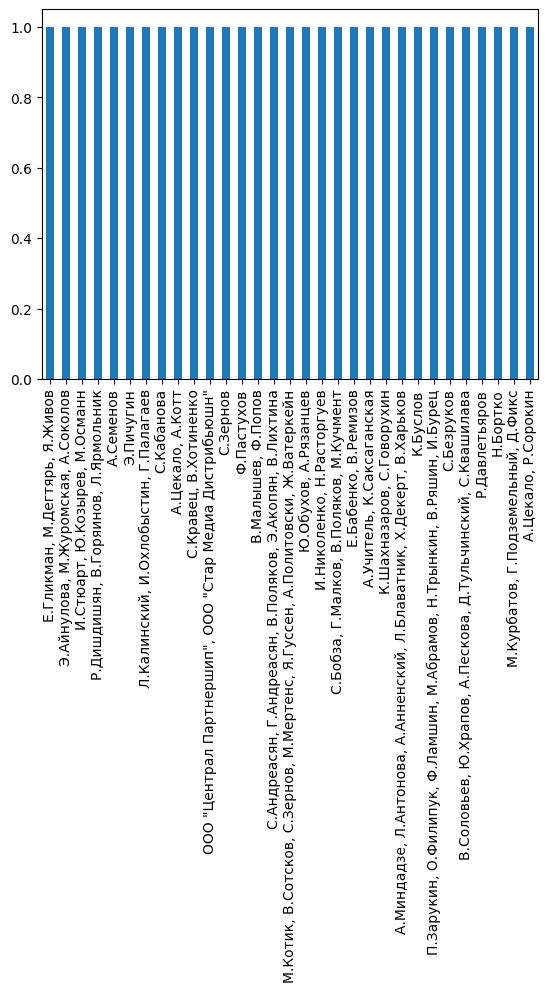

In [70]:
succeded_subsidized["producer"].value_counts().loc[succeded_subsidized["producer"].value_counts() > 0].plot.bar();

Выяснили, какие продюсеры чаще создают коммерчески успешные картины с учётом субсидирования.

Далее проанализируем, какие проекты наоборот с большой долей вероятности не добъются коммерческого успеха. Выделим те из них, успешность которых хуже медианной.

In [71]:

failed_subsidized = no_outliers.loc[no_outliers.index.difference(succeded_subsidized.index)] \
    .query("box_office.notna() and financing_source.notna() and box_office <= refundable_support + nonrefundable_support")
failed_subsidized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  0 non-null      object        
 1   puNumber               0 non-null      UInt32        
 2   show_start_date        0 non-null      datetime64[ns]
 3   type                   0 non-null      category      
 4   film_studio            0 non-null      object        
 5   production_country     0 non-null      category      
 6   director               0 non-null      object        
 7   producer               0 non-null      object        
 8   age_restriction        0 non-null      uint8         
 9   refundable_support     0 non-null      float64       
 10  nonrefundable_support  0 non-null      float64       
 11  budget                 0 non-null      float64       
 12  financing_source       0 non-null      category      
 13  ratings          

Т.к. таких фильмов слишком мало, нет смысла анализировать их характеристики потому что выборка не репрезентативна.

### Проанализируем зависимость рейтинга проектов от субсидий 

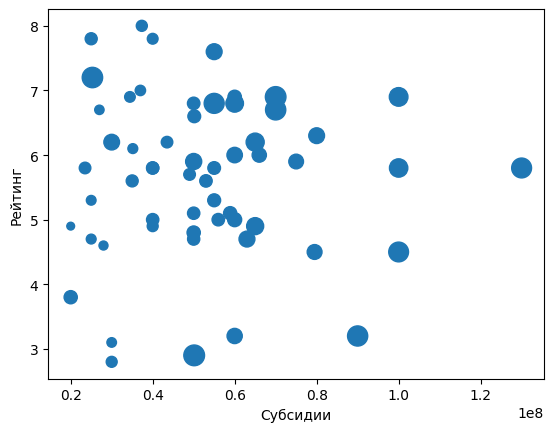

In [72]:


plt.scatter(x=subsidized["grants"], y=subsidized["ratings"], s=subsidized["budget"] / 10 ** 6);
plt.xlabel("Субсидии")
plt.ylabel("Рейтинг")
plt.show()

Делаем вывод, что влияние бюджета на рейтинг незначительно. При этом часто наилучшие показатили рейтинга встречаются у картин, размер субсидий которых менее 70_000_000 рублей. Из этого можно сделать вывод, что финансирование на большие суммы часто бывает неэффективно.

## Oбщий вывод

В исследовании была произведена подготовка данных:
 - преобразование типов данных
 - объединение источников данных в один набор
 - анализ пропусков в данных
 - устранение дубликатов
 - создан набор данных без выбросов в количественных данных 
 - созданы для удобства синтетические атрибуты данных

В ходе подготовки данных ознакомились с основными количественными и качественными характеристиками данных.

Анализ показал, что:
 - Количество новых фильмов часто менялось год от года.
 - Доля фильмов с указанными кассовыми сборами: 41.89%
 - Количество информации о фильмах росло год от года. Наиболее полные данные представлены за 2015-2018 годы
 - Сумма кассовых сборов увеличивалась с 2013 года и достигла максимальных значений в 2016+ годах. Наибольшие кассовые сборы со всех фильмов пришлись на 2018 год. Минимальные же сборы были в 2013, 2014 годах.
 - С 2013 года в прокате начали с каждым годом всё чаще появляться всё более и более успешные относительно других актуальных фильмов картины.
 - Наиболее успешны в прокате фильмы с возрастной категорией 6+. Однако появилась гипотеза, что в силу демографических изменений этот тренд меняется в 2017 году т.к. в целевой аудитории 12+, вероятно, становится больше зрителей.
 - Суммарные субсидии с большего растут год от года.
 - Количество субсидий отдалённо напоминает динамику суммарных кассовых сборов.
 - Малая часть фильмов смогла превзойти размер временных субсидий кассовыми сборами.
 - Незначительная часть проектов собирают в прокате больше, чем получают безвозмездных субсидий.
 - Коммерчески успешными субсидируемыми проектами чаще всего являются художественные в жанре драмы, комедии, мелодрамы, триллера и мюзикла.
 - Удалось выделить списки студий, режиссёров и продюссеров, которые чаще остальных выпускают коммерчески успешные картины.
 - Влияние бюджета на рейтинг незначительно.
 - Финансирование на большие чем 70_000_000 рублей суммы часто бывает неэффективно.